# Import the packages

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Import the dataframe

In [90]:
df: pd.DataFrame = pd.read_csv('../Datasets/trainingdata.csv', sep=',')
df.head()

,startdatum,leeftijd,dienstperiode,status_jaar,status_actief,status_beëindigd,reisafstand,uitdienst_reden_Niet van toepassing,uitdienst_reden_Ontslag,uitdienst_reden_Vertrek,aantal_geboortes,afdeling,business_unit
0,2013-05-23 05:06:00,29.0,NaN,2018,1,0,53,True,False,False,"7,8",BI,Detachering
1,2010-04-24 05:06:00,33.0,NaN,2016,1,0,50,True,False,False,"11,9",Accountant,Detachering
2,2006-06-09 05:06:00,42.0,NaN,2018,1,0,53,True,False,False,"10,9",BI,Detachering
3,2018-04-28 05:06:00,20.0,NaN,2018,1,0,50,True,False,False,"11,9",BI,Detachering
4,2009-01-09 05:06:00,32.0,NaN,2013,1,0,115,True,False,False,"10,2",Accountant,Detachering


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48849 entries, 0 to 48848
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   startdatum                           48849 non-null  object 
 1   leeftijd                             48849 non-null  float64
 2   dienstperiode                        0 non-null      float64
 3   status_jaar                          48849 non-null  int64  
 4   status_actief                        48849 non-null  int64  
 5   status_beëindigd                     48849 non-null  int64  
 6   reisafstand                          48849 non-null  int64  
 7   uitdienst_reden_Niet van toepassing  48849 non-null  bool   
 8   uitdienst_reden_Ontslag              48849 non-null  bool   
 9   uitdienst_reden_Vertrek              48849 non-null  bool   
 10  aantal_geboortes                     48849 non-null  object 
 11  afdeling                    

In [92]:
X, y = df.drop('uitdienst_reden_Vertrek', axis=1), df[['uitdienst_reden_Vertrek']]

In [93]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

In [94]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [96]:
# Define hyperparameters
params = {
    "objective": "reg:squarederror",
    "eta": 0.05,  # Learning rate - controls the step size during training
    "max_depth": 8,  # Maximum depth of a tree - controls the complexity of the trees
    "min_child_weight": 5,  # Minimum sum of instance weight needed in a child
    "gamma": 0.1,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.001,  # L1 regularization term on weights
    "reg_lambda": 1.0,  # L2 regularization term on weights
    "n_estimators": 1000,  # Number of boosting rounds or trees
    "early_stopping_rounds": 50,  # Stop training if no improvement in the validation metric after this number of rounds
    "eval_metric": "rmse"  # Evaluation metric to use
}

# Training the XGBoost model
num_boost_round = 1000
model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=num_boost_round,
    evals=[(dtrain_reg, "Train"), (dtest_reg, "Validation")],  # Adding a validation set for monitoring
    early_stopping_rounds=params["early_stopping_rounds"],  # Early stopping based on the validation set
    verbose_eval=50  # Display evaluation results every 50 rounds
)

[0]	Train-rmse:0.08389	Validation-rmse:0.08456


/home/shaeme/I4talent_project/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:40:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	Train-rmse:0.01179	Validation-rmse:0.01367
[100]	Train-rmse:0.00591	Validation-rmse:0.00738
[150]	Train-rmse:0.00588	Validation-rmse:0.00734
[200]	Train-rmse:0.00588	Validation-rmse:0.00734
[250]	Train-rmse:0.00588	Validation-rmse:0.00734
[275]	Train-rmse:0.00588	Validation-rmse:0.00734


In [97]:
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_reg)

In [98]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in preds]

rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')

# Generate classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_binary))

# Generate confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_binary))

RMSE of the base model: 0.007
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      9692
        True       1.00      1.00      1.00        78

    accuracy                           1.00      9770
   macro avg       1.00      1.00      1.00      9770
weighted avg       1.00      1.00      1.00      9770

Confusion Matrix:
[[9692    0]
 [   0   78]]


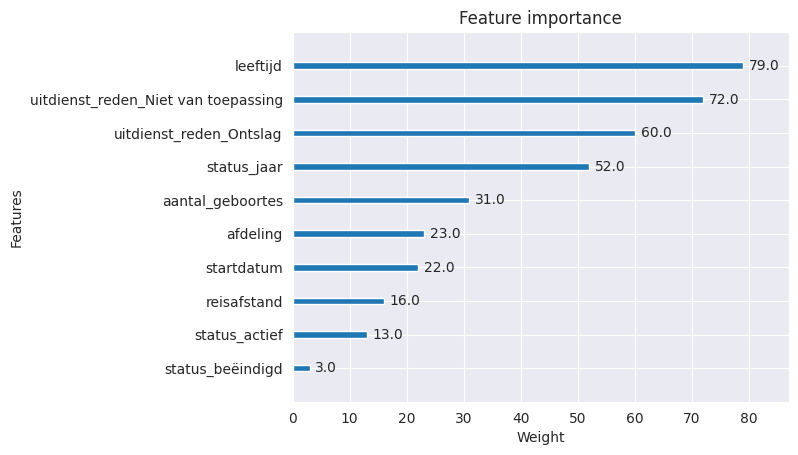

In [99]:
xgb.plot_importance(model, importance_type='weight', xlabel='Weight')
plt.show()

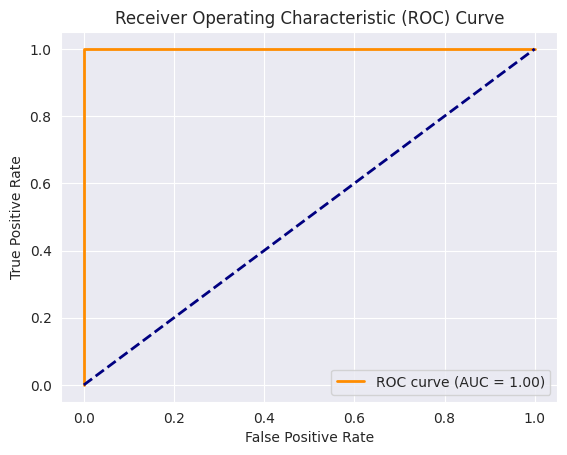

In [100]:
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


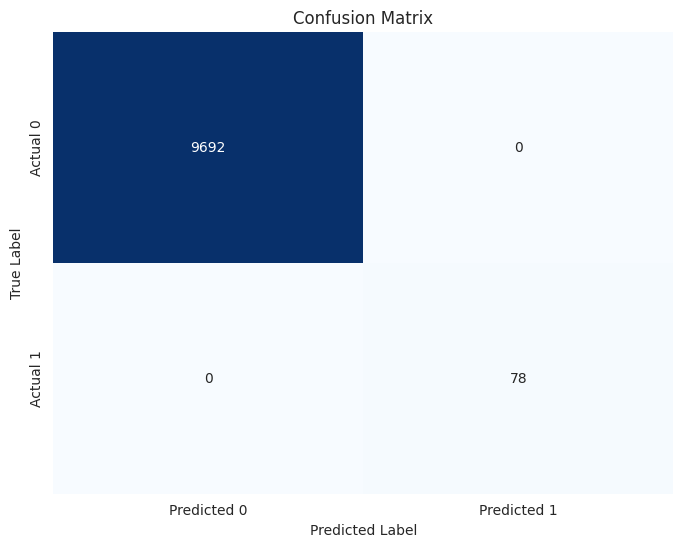

In [101]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()